# Jet Vane Speed
This document assesses the required speed for the jet vane actuators. My analysis approach is to make a 2-dimensional linear model of the lateral dynamics of the vehicle, and then examine the frequency domain properties of this model to determine the required actuator speed.

I believe that the (linear) vehicle dynamics do not contain any fundamental time scales. Rather, the requirements for actuator speed are driven by the desired precision of position control.

## Lateral dynamics model
The lateral dynamics model captures the vehicle's lateral motion in a 2d-plane. It tracks two elements of the vehicle's pose: the horizontal position $x$ and the pitch-over angle $\theta$. There is a single control input $\alpha$, which is the angle of attack of the (two) vane(s) that rotate in this plane. I assume that the jet thrust $F_j$ is fixed.

![Dynamics model diagram](2d_model_diagram.png)

Thus the state is:

\begin{equation}
X = [\theta, x, \dot{\theta}, \dot{x}]^T
\end{equation}

And the control input is:
\begin{equation}
U = [\alpha]
\end{equation}

The angular momentum equation is:

\begin{equation}
L_v r_v = I \ddot{\theta}
\end{equation}

Where $L_v$ is the lift force of the (two) vane(s), $r_v$ is the vane distance from the center of mass, and $I$ is the vehicle moment of inertial about an axis normal to the plane of motion which passes thru the center of mass.

The linear momentum equation is:

\begin{equation}
-(F_j - D_v) \sin\theta + L_v \cos\theta = m \ddot{x}
\end{equation}

where $D_v$ is the drag force on a vane and $m$ is the vehicle mass.

The aerodynamics model is:

\begin{equation}
L_v = \frac{1}{2} \rho_j v_j^2 C_L S_v
\\
D_v = \frac{1}{2} \rho_j v_j^2 C_D S_v
\end{equation}

where $\rho_j$ is the exhaust jet density, $v_j$ is the exhaust jet velocity, $C_L, C_D$ and the lift and drag coefficients of the vane, and $S_v$ is the vane area (2x for two vanes). Note that $F_j = A_j \rho_j v_j^2$, where $A_j$ is the jet exit area. Further, assume $C_L = 2 \pi \alpha$ and $C_D = C_{D0} + C_{D \alpha} \alpha^2$.

Now, linearize these equations for small $\theta$ (i.e. $\sin\theta \rightarrow \theta$):

\begin{equation}
\ddot{\theta} = - \pi \frac{S_v}{A_j} \frac{F_j r_v}{I} \alpha = b_3 \alpha
\end{equation}

\begin{equation}
\ddot{x} = -\frac{F_j}{m} \left( 1 - \frac{1}{2} \frac{S_v}{A_j} C_{DO} \right) \theta - \pi \frac{S_v}{A_j} \frac{F_j}{m} \alpha = a_{41} \theta + b_4 \alpha
\end{equation}

### Linearized state space form
In the state space form, the system equations are:

\begin{equation}
\dot{X} = A X + B U
\end{equation}

\begin{equation}
 \begin{bmatrix}
  \dot{\theta} \\ 
  \dot{x} \\
  \ddot{\theta} \\
  \ddot{x}
 \end{bmatrix}
 =
 \begin{bmatrix}
  0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 1 \\
  0 & 0 & 0 & 0 \\
  a_{41} & 0 & 0 & 0
 \end{bmatrix}
 \begin{bmatrix}
  \theta \\ 
  x \\
  \dot{\theta} \\
  \dot{x}
 \end{bmatrix}
 +
 \begin{bmatrix}
  0 \\ 
  0 \\
  b_3 \\
  b_4
 \end{bmatrix}
 \alpha
\end{equation}

The $A$ matrix has all-zero eigenvalues, so the (open-loop) linearized system has marginal stability. Unfortunately, the eigenvalues do not give us an inherent timescale for the vehicle dynamics.



### Transfer functions
Consider the Laplace-domain transfer functions of the system. Let $A(s) = \mathscr{L}[\alpha(t)]$, $\Theta(s) = \mathscr{L}[\theta(t)]$, and $X(s) = \mathscr{L}[x(t)]$ be the Laplace transforms of vane angle of attack, pitch-over, and position.

The transfer function from vane angle to pitch is:

\begin{equation}
G_\theta(s) = \frac{\Theta(s)}{A(s)} = \frac{b_3}{s^2}
\end{equation}

The transfer function from vane angle to horizontal position is:
\begin{equation}
G_x(s) = \frac{X(s)}{A(s)} = \frac{b_4 s^2 + a_{41}b_3}{s^4}
\end{equation}

This transfer function has a quadruple pole at the origin. This matches the four 0 eigenvalues of the state space model. The transfer from vane angle to vehicle position contains a four-fold integrator: $\alpha$ drives $\ddot{\theta}$, and $\theta$ drives $\ddot{x}$.

Again, the poles of the system do not set a fundamental time scale for the vehicle dynamics.


## Frequency Domain Analysis / Bode Plots
In this section I use frequency domain analysis to show a relationship between the actuator speed and the precision/finesse with which the vehicle's position and pitch can be set.

We will use a numerical model of the system to make the frequency domain plots, so start by computing values for the above parameters:

In [1]:
import numpy as np
from scipy import signal
%matplotlib notebook
import matplotlib.pyplot as plt
import pint
ureg = pint.UnitRegistry()
from lti_model import plot_bode

# Physical properties of vehicle.
F_j = 160 * ureg.N   # Jet thrust.
m = 10. * ureg.kg    # Vehicle mass.
I = 2 / 5. * m * (0.2 * ureg.m)**2    # Vehicle moment of inertia about com in lateral plane.
r_v = 0.2 * ureg.m    # Vane distance from vehicle center of mass.
S_v = 2 * (20 * ureg.mm) * (15 * ureg.mm)    # Jet vane area (2 vanes per lateral plane).
A_j = np.pi * (54 * ureg.mm / 2)**2    # Jet exit area.
C_D0 = 0.05    # Jet vane drag coefficient minimum.

# Coefficients of linear dynamic model.
b_3_dimensioned = -np.pi * (S_v / A_j) * F_j * r_v / I
b_3_dimensioned.ito(ureg.s**-2)
b_3 = b_3_dimensioned.magnitude

b_4_dimensioned = -np.pi * (S_v / A_j) * F_j / m
b_4_dimensioned.ito(ureg.m * ureg.s**-2)
b_4 = b_4_dimensioned.magnitude

a_41_dimensioned = - (F_j / m) * (1 - 0.5 * (S_v / A_j) * C_D0)
a_41_dimensioned.ito(ureg.m * ureg.s**-2)
a_41 = a_41_dimensioned.magnitude

print('b_3 = {:.4f}'.format(b_3))
print('b_4 = {:.4f}'.format(b_4))
print('a_41 = {:.4f}'.format(a_41))

b_3 = -164.6091
b_4 = -13.1687
a_41 = -15.8952


Next, create scipy objects for the transfer functions, and generate bode plots:

<IPython.core.display.Javascript object>


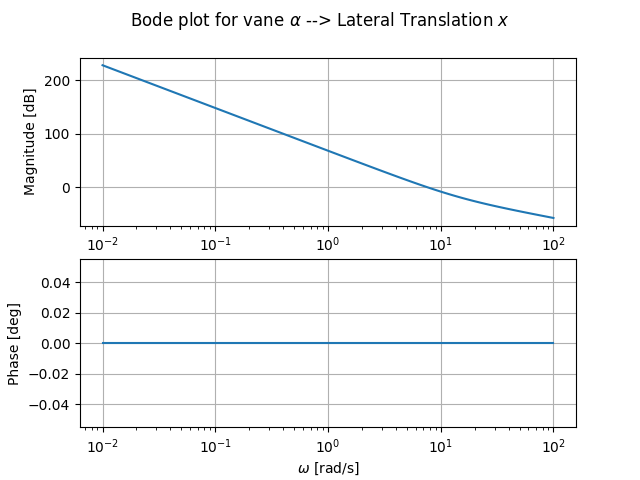

<IPython.core.display.Javascript object>


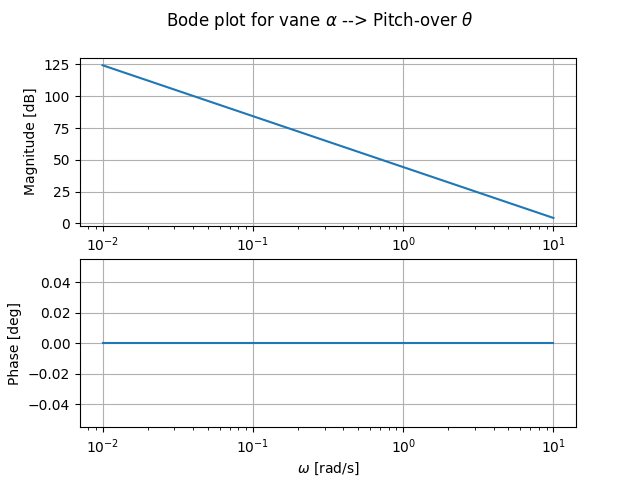

Text(0.5,0.98,'Bode plot for vane $\\alpha$ --> Pitch-over $\\theta$')

In [2]:
# Create TF system model for vane aoa --> pitch-over
sys_ang = signal.TransferFunction([b_3], [1, 0, 0])

# Create TF system model for vane aoa --> translation
sys_trans = signal.TransferFunction([b_4, 0, a_41 * b_3], [1, 0, 0, 0, 0])

# Plot bode plot
plot_bode(sys_trans)
plt.suptitle('Bode plot for vane $\\alpha$ --> Lateral Translation $x$')
plot_bode(sys_ang)
plt.suptitle('Bode plot for vane $\\alpha$ --> Pitch-over $\\theta$')

### Interpreting the Bode Plot Gain
The gain on the bode plot is the scaling from a sinusoidal drive of the vane angle to the amplitude of the resulting position oscillations. For example, assume the gain is $g_x(\omega)$ at some frequency $\omega$, and the vane is driven with $\alpha(t) = \alpha_{ref} \sin(\omega t)$. This input will result in a sinusoidal oscillation in the vehicle position (if the oscillation amplitude is small enough that the pitch stays in the linear regime). The position oscillation will be:

\begin{equation}
x(t) = g_x(\omega) \alpha_{ref} \sin(\omega t + \phi(\omega))
\end{equation}

The above bode plots show that the gain decreases with increasing frequency. Driving the vane slowly will result in large oscillations of position, but driving the vane quickly will only result in small position oscillations. Thus, **the finest position change we wish to drive sets the speed with which we must drive the actuator**.

The following figure presents the gain information from the Bode plot in a more intuitive form. The driving frequency $\omega$ is shown on the horizontal axis. The vertical axis shows the amplitude of the pitch and position oscillations which result from driving the vane angle at $\alpha(t) = \alpha_{ref} \sin(\omega t)$, with $\alpha_{ref} = 1$ degree.

The figure also shows the fastest drive frequency that an example servo can support. The servo has a rated maximum speed $\dot{\alpha}_{max}$, we must have:

\begin{equation}
\dot{\alpha}_{max} > \frac{d\alpha}{dt}
\\
\omega < \frac{\dot{\alpha}_{max}}{\alpha_{ref}}
\end{equation}

The code also takes into account the change in $\dot{\alpha}_{max}$ due to the gearing between the servo and the vane shaft.

<IPython.core.display.Javascript object>


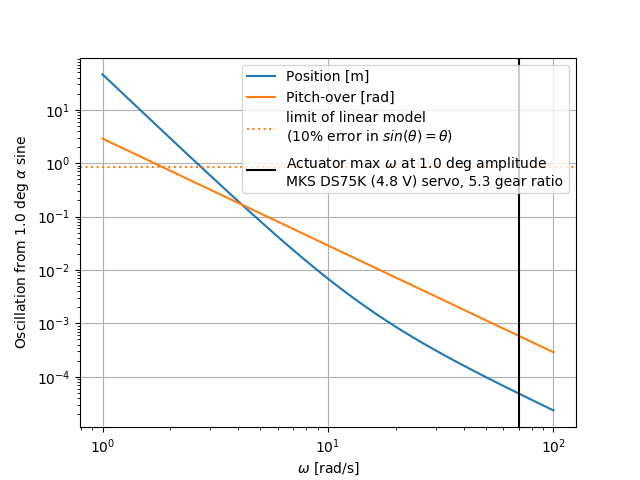

In [8]:
# Plot "finesse" vs. frequency
plt.figure()
ref_a = np.deg2rad(1)
w, mag, phase = signal.bode(sys_trans, w=np.logspace(0, 2))
gain = 10**(mag / 20)
x_finess = gain * ref_a
plt.loglog(w, x_finess, label='Position [m]')

w, mag, phase = signal.bode(sys_ang, w=np.logspace(0, 2))
gain = 10**(mag / 20)
theta_finess = gain * ref_a
plt.loglog(w, theta_finess, label='Pitch-over [rad]')
plt.axhline(y=0.85, label='limit of linear model \n(10% error in $sin(\\theta)=\\theta$)', color='C1', linestyle=':')

# Plot servo max speed for reference
servo = 'MKS DS75K (4.8 V)'
servo_speed = np.deg2rad(60) / 0.16    # Servo speed [units: radian second**-1].
gear_ratio = 64 / 12.
actuator_speed = servo_speed / gear_ratio
w_max_act = actuator_speed / ref_a
plt.axvline(x=w_max_act, label=('Actuator max $\\omega$ at {:.1f} deg amplitude\n'.format(np.rad2deg(ref_a))
    + '{:s} servo, {:.1f} gear ratio'.format(servo, gear_ratio)), color='black')

plt.legend()
plt.xlabel('$\\omega$ [rad/s]')
plt.ylabel('Oscillation from {:.1f} deg $\\alpha$ sine'.format(np.rad2deg(ref_a)))
plt.grid(True)

plt.show()

At the actuator's maximum drive frequency (black vertical line, about 70 Hz), a 1 degree amplitude $\alpha$ sine would produce very small amplitude oscillations in vehicle position (blue) and vehicle pitch (orange) (< 0.1 mm, < 1 mrad). Thus, I conclude that the actuator is sufficiently fast to drive the vehicle dynamics with the desired precision.